# **Enhancing Email Communication with AI: Mitigating Misinterpretation through Sentiment and Tone Analysis**

In [2]:
# Dependencies to be installed
!pip install ipython language_tool_python matplotlib nltk pandas spacy textstat torch transformers

In [3]:
# Libraries to be imported
import language_tool_python
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy
import textstat
import torch
from transformers import pipeline

from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import re

## **Part 1: Check Spelling and Grammar**

Using **Natural Language Processing (NLP)** tools, the function analyzes the email text for linguistic issues and provides actionable corrections. By allowing users to interactively choose corrections or provide their own replacements, this tool ensures flexibility and user engagement while enhancing the overall quality and professionalism of the text.

### **Tools Used**
1. **LanguageTool (via `language_tool_python`)**:
  - An open-source grammar and style checker capable of identifying a wide range of grammatical, spelling, and stylistic issues.
  - Provides detailed suggestions and explanations for detected errors.
2. **Python (Interactive Corrections)**:
  - Implements a user-friendly interface to review and apply corrections sequentially.
  - Dynamically adjusts the content during corrections to maintain the integrity of offsets.

### **Key Features**
1. **Interactive Correction Process**:
  - Allows the user to select suggestions or provide custom corrections.
2. **Error Breakdown Chart**:
  - Displays the distribution of error types (Grammar, Spelling, Style) as a bar chart.
3. **Error Resolution Timeline**:
  - Allows the user to select suggestions or provide custom corrections.

In [4]:
def check_grammar_and_spelling(email_content):
    """
    Checks the grammar and spelling of the given email content, provides corrections,
    and generates visualizations (Error Breakdown Chart and Error Resolution Timeline).

    Args:
        email_content (str): The text of the email to analyze.

    Returns:
        dict: A dictionary with the following keys:
              - "issues" (list): A list of grammar and spelling issues detected.
              - "corrected_email" (str): The corrected version of the email.
    """
    # Initialize the LanguageTool object for English
    tool = language_tool_python.LanguageTool('en-US')

    # Detect grammar and spelling issues
    matches = tool.check(email_content)

    # Extract details of each match
    issues = []
    for match in matches:
        issues.append({
            "message": match.message,
            "suggestions": match.replacements,
            "offset": match.offset,
            "error_length": match.errorLength,
            "error_text": email_content[match.offset:match.offset + match.errorLength],
            "type": "Grammar" if "grammar" in match.ruleId.lower() else "Spelling" if "spelling" in match.ruleId.lower() else "Style"
        })

    # Sort matches by offset to apply corrections sequentially
    issues = sorted(issues, key=lambda x: x['offset'])

    # Interactive correction process
    print("Detected Issues:")
    corrected_content = email_content
    adjustment = 0  # Tracks cumulative changes to the offset
    correction_steps = []

    for i, issue in enumerate(issues):
      # Adjust offset for changes made to previous text
      adjusted_offset = issue['offset'] + adjustment

      # Skip if adjusted offset is invalid or overlaps corrected content
      if adjusted_offset < 0 or adjusted_offset >= len(corrected_content):
          continue

      print(f"\nError: '{issue['error_text']}' ({issue['message']})")
      if issue['suggestions']:
          print("Suggestions:")
          for j, suggestion in enumerate(issue['suggestions'], 1):
              print(f"  {j}: {suggestion}")
          print("  0: Enter a custom replacement")
      else:
          print("No suggestions available. Enter your own replacement.")

      while True:
          user_choice = input("Choose a suggestion (number) or provide your replacement: ")
          if user_choice.isdigit():
              choice_index = int(user_choice)
              if 0 <= choice_index <= len(issue['suggestions']):
                  # Apply suggestion or prompt for custom replacement
                  if choice_index == 0:
                      custom_replacement = input("Enter your replacement: ")
                  else:
                      custom_replacement = issue['suggestions'][choice_index - 1]

                  # Log step
                  correction_steps.append({
                      "step": i + 1,
                      "error": issue["error_text"],
                      "correction": custom_replacement
                  })

                  # Apply replacement and update offset adjustment
                  corrected_content = (
                      corrected_content[:adjusted_offset] +
                      custom_replacement +
                      corrected_content[adjusted_offset + issue['error_length']:]
                  )
                  adjustment += len(custom_replacement) - issue['error_length']
                  break
              else:
                  print("Invalid choice. Please enter a valid number.")
          else:
              print("Invalid input. Please enter a number.")

    # Visualization: Error Breakdown Chart
    error_types = [issue["type"] for issue in issues]
    error_counts = {etype: error_types.count(etype) for etype in set(error_types)}

    plt.figure(figsize=(8, 6))
    plt.bar(error_counts.keys(), error_counts.values(), color=["skyblue", "lightgreen", "salmon"])
    plt.title("Error Breakdown")
    plt.xlabel("Error Type")
    plt.ylabel("Count")
    plt.show()

    # Visualization: Error Resolution Timeline
    if correction_steps:
        steps = [step["step"] for step in correction_steps]
        errors = [step["error"] for step in correction_steps]
        corrections = [step["correction"] for step in correction_steps]

        plt.figure(figsize=(10, 6))
        plt.plot(steps, errors, label="Errors", marker="o", linestyle="--", color="lightblue")
        plt.plot(steps, corrections, label="Corrections", marker="x", linestyle="-", color="lightgreen")
        plt.title("Error Resolution Timeline")
        plt.xlabel("Step")
        plt.xticks(steps)
        plt.ylabel("Text")
        plt.legend()
        plt.grid()
        plt.show()

    # Print the final corrected content
    print("\nFinal Corrected Content:")
    print(corrected_content)

    return {
        "issues": issues,
        "corrected_email": corrected_content,
        "correction_steps": correction_steps
    }



Detected Issues:

Error: 'youre' (Possible spelling mistake found.)
Suggestions:
  1: you're
  0: Enter a custom replacement
Choose a suggestion (number) or provide your replacement: 1

Error: 'doesn't' (Possible verb agreement error — use the base form here.)
Suggestions:
  1: don't
  0: Enter a custom replacement
Choose a suggestion (number) or provide your replacement: 1

Error: 'roode' (Possible spelling mistake found.)
Suggestions:
  1: rode
  2: Rhode
  3: Goode
  4: rood
  5: roods
  6: rewed
  0: Enter a custom replacement
Choose a suggestion (number) or provide your replacement: 0
Enter your replacement: rude

Error: 'I' (Three successive sentences begin with the same word. Consider rewording the sentence or use a thesaurus to find a synonym.)
Suggestions:
  1: Furthermore, I
  2: Likewise, I
  3: Not only that, but I
  0: Enter a custom replacement
Choose a suggestion (number) or provide your replacement: 1

Error: 'missd' (Possible spelling mistake found.)
Suggestions:
  1: 

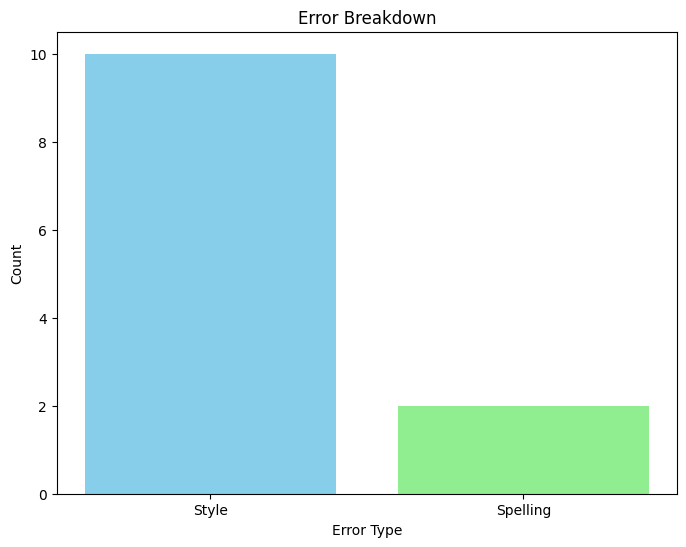

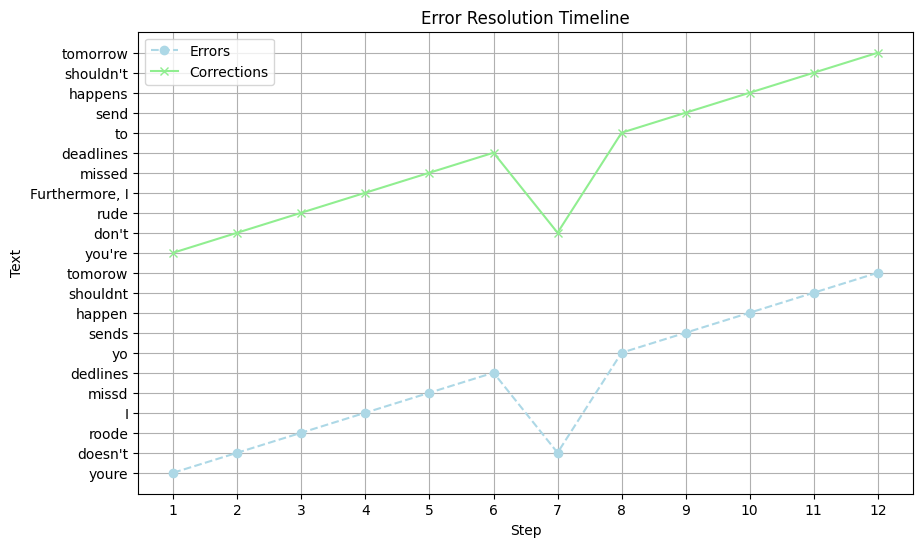


Final Corrected Content:

Hi John,

I hope you're doing well. I don't mean to be rude, but we really need to talk about the report.
Furthermore, I am very upset about the missed deadlines. On offends but you are losers. I'm glad I don't work with you.
You always say to will send it, but it never happens. I shouldn't have to remind again.
Please get it to me bye tomorrow.

Best,
Mark


Final Corrected Content:

Hi John,

I hope you're doing well. I don't mean to be rude, but we really need to talk about the report.
Furthermore, I am very upset about the missed deadlines. On offends but you are losers. I'm glad I don't work with you.
You always say to will send it, but it never happens. I shouldn't have to remind again.
Please get it to me bye tomorrow.

Best,
Mark



In [100]:
# # Example email content
# email_content = """
# Hi team,

# I wanted to tells yall that the project's dely is causing some problems.
# We need to discusses this further. Can you gives me a update?

# Thanks,
# Jane
# """

# email_content = """
# Hi Team,

# I hope this emial finds you well. I think we needs to have an honest discuss about the delays in our projet. You alway say the deadlines are manageble, but they never seem to be met.

# Maybe we could of planned better, but I shouldn’t of have to constantly follow up. No offense, but it feel like some of you aren’t taking ownership of your task.

# I beleive we can turn this around, but I’m concern about how this might effect our client relationship. Could we perhaps revisit the task allocations and insure everyone understands their responsibilites?

# Also, just saying, it might be helpful if everyone shares there updates during tommorow’s meeting. That way, their’s no confusion about progress.

# Please review your tasks before the meeting and come prepard with any suggestion for improvement.

# Thnaks,
# Alex
# """

email_content = """
Hi John,

I hope youre doing well. I doesn't mean to be roode, but we really need to talk about the report.
I am very upset about the missd dedlines. On offends but you are losers. I'm glad I doesn't work with you.
You always say yo will sends it, but it never happen. I shouldnt have to remind again.
Please get it to me bye tomorow.

Best,
Mark
"""

# # Examply 1, just very poorly written:
# email_content = """
# Hey,

# So, like, I’m kind of feeling weird about this whole thing. I mean, it’s cool and all, but at the same time, it’s not really what I was expecting. I guess I’m just a little confused right now.

# I don’t know, maybe we should just forget about it. Or maybe we could try again? I’m not sure.

# Whatever.
# """

# # Passive Agressive
# email_content = """
# Hi Sarah,

# I hope youre well. I just want to check in again since I hasn’t herd back from you about the report. I’m sure you’re very busy, but it’s a little surprising that something so smiple is taking this long.

# I assumed we agreed to have it done by last week, but maybe I misunderstood? If there’s some issue you need help with, you could’ve mentioned it earlier. Waiting on this is really holding up my work.

# Let me know when I can finally expect it. Hopefully soon, because I have other priorities that can’t keep waiting.

# Thanks,
# James
# """

# email_content = """
# Hi Team,

# I hope this email finds you wel. I think we shuld maybe think about revising the timleine for this project becase things arent going quite as we hoped. It’s like, not what I was expecting. Some people sem to be struggling to commit to there tasks, which I gess is understandable since everyone’s busy, but it stil feels dissapointing.

# Im not saying its anyones fault, but also, its kind of dissapointing to see deadlines being missed over and over. We agreed that the deadlines were manageble, didnt we? Mabye we should of been more clear about what we expexted. Or mabye not everyone was really taking it seriously enuf.

# Look, I do appreciate all the hard work that everyone’s doing, I realy do. But we need to fix this. Could we try sticking to the deadlines this time? Or shoud we just forget deadlines all together?

# Lemme know what you think.

# Thanx,
# Alex
# """

# email_content = """
# Hi team,

# I think, maybe, we should kinda revisit the project timline becuz some ppl arent really commited to the dedlines. It's not totally working, but I guess we could try harder? Or, maybe we shuld just forget about it and move on?

# Theres also been some confushion abot who’s responsible for wht, and I thik its fair to say that things are not super clear right now. It might be a good idea to, you know, discuss this in the next meeting? Or, I don’t know, we could just leave it as is?

# Also, someone said the documantation was updated, but im not sure if evryone has access to it. Maybe we shuld figger out a way to ensure better communication, or maybe it dosent matter? Let me no wht you think.

# Thanx.
# """

# Analyze grammar and spelling interactively
result = check_grammar_and_spelling(email_content)

# # Print the final corrected content
print("\nFinal Corrected Content:")
print(result["corrected_email"])


In [101]:
result['correction_steps']

[{'step': 1, 'error': 'youre', 'correction': "you're"},
 {'step': 2, 'error': "doesn't", 'correction': "don't"},
 {'step': 3, 'error': 'roode', 'correction': 'rude'},
 {'step': 4, 'error': 'I', 'correction': 'Furthermore, I'},
 {'step': 5, 'error': 'missd', 'correction': 'missed'},
 {'step': 6, 'error': 'dedlines', 'correction': 'deadlines'},
 {'step': 7, 'error': "doesn't", 'correction': "don't"},
 {'step': 8, 'error': 'yo', 'correction': 'to'},
 {'step': 9, 'error': 'sends', 'correction': 'send'},
 {'step': 10, 'error': 'happen', 'correction': 'happens'},
 {'step': 11, 'error': 'shouldnt', 'correction': "shouldn't"},
 {'step': 12, 'error': 'tomorow', 'correction': 'tomorrow'}]

In [102]:
result['issues']

[{'message': 'Possible spelling mistake found.',
  'suggestions': ["you're"],
  'offset': 18,
  'error_length': 5,
  'error_text': 'youre',
  'type': 'Spelling'},
 {'message': 'Possible verb agreement error — use the base form here.',
  'suggestions': ["don't"],
  'offset': 38,
  'error_length': 7,
  'error_text': "doesn't",
  'type': 'Style'},
 {'message': 'Possible spelling mistake found.',
  'suggestions': ['rode', 'Rhode', 'Goode', 'rood', 'roods', 'rewed'],
  'offset': 57,
  'error_length': 5,
  'error_text': 'roode',
  'type': 'Style'},
 {'message': 'Three successive sentences begin with the same word. Consider rewording the sentence or use a thesaurus to find a synonym.',
  'suggestions': ['Furthermore, I', 'Likewise, I', 'Not only that, but I'],
  'offset': 109,
  'error_length': 1,
  'error_text': 'I',
  'type': 'Style'},
 {'message': 'Possible spelling mistake found.',
  'suggestions': ['missed', 'miss', 'Missy', 'Miss'],
  'offset': 135,
  'error_length': 5,
  'error_text': 

## **Part 2: Clarity and Readability Check**

Clarity and readability check is added before sentiment analysis with the understanding that enhanced clarity can help improve the accuracy of sentiment analysis by eliminating ambiguity. This is essential for reducing misunderstandings in email correspondence.

**Tools Used**
1. **TextStat Library**:
- A Python library used to calculate various readability metrics.


- **Key Metrics Used**:
  -  **Flesch Reading Ease**:
    - A higher score means that the text is easier to read.
  - **Flesch-Kincaid Grade Level**:
    - Represents the US school grade requied to understand the text.
  - **Dale-Chall Readability Score**:
    - Measures how difficult words are in a text.
    - A lower score means easier readability.
  - **Reading Time (minutes)**:
    - Provides an estimated reading time based on a standard reading speed.

2. **Pandas Library**:
- Used to organize readability metrics into a tabular format.

3. **Matplotlib Library**:
- Used to create visual representations of the readability metrics.
- **Visualizations**:
  - **Bar Chart for Original Text**:
    - Highlights the readability metrics of the original content.
  - **Comparison Chart**:
    - Displays side-by-side comparisons of metrics for the original and corrected text, showcasing improvements.

In [103]:
def analyze_readability(original_text, corrected_text=None):
    """
    Analyze the readability of the given text and optionally compare it with corrected text.

    Args:
        original_text (str): The original text to analyze.
        corrected_text (str, optional): The corrected text to compare against the original.

    Returns:
        pd.DataFrame: A DataFrame containing readability metrics for the original and optionally corrected text.
    """
    # Calculate readability scores for the original text
    original_scores = {
        "Flesch Reading Ease": textstat.flesch_reading_ease(original_text),
        "Grade Level": textstat.flesch_kincaid_grade(original_text),
        "Dale-Chall Readability Score": textstat.dale_chall_readability_score(original_text),
        "Reading Time (minutes)": round(len(original_text.split()) / 200, 2)  # Assuming 200 words per minute
    }

    # Initialize corrected scores as None
    corrected_scores = None

    if corrected_text:
        # Calculate readability scores for the corrected text
        corrected_scores = {
            "Flesch Reading Ease": textstat.flesch_reading_ease(corrected_text),
            "Grade Level": textstat.flesch_kincaid_grade(corrected_text),
            "Dale-Chall Readability Score": textstat.dale_chall_readability_score(corrected_text),
            "Reading Time (minutes)": round(len(corrected_text.split()) / 200, 2)
        }

        # Create a DataFrame for comparison
        df = pd.DataFrame([original_scores, corrected_scores], index=["Original", "Corrected"])
        # print("\nReadability Metrics Comparison:")
        # print(df)

        # Prepare data for comparison visualization
        labels = list(original_scores.keys())
        original_values = [original_scores[metric] for metric in labels]
        corrected_values = [corrected_scores[metric] for metric in labels]

        # Create a bar chart for readability comparison
        x = range(len(labels))
        plt.figure(figsize=(12, 6))
        plt.bar(x, original_values, width=0.4, label='Original', color='lightblue', align='center')
        plt.bar([pos + 0.4 for pos in x], corrected_values, width=0.4, label='Corrected', color='lightgreen', align='center')

        # Add chart details
        plt.title("Comparison of Readability Metrics: Original vs. Corrected")
        plt.xlabel("Readability Metrics")
        plt.ylabel("Scores")
        plt.xticks([pos + 0.2 for pos in x], labels, rotation=45, ha="right")
        plt.legend()
        plt.tight_layout()
        plt.show()

    else:
        # Create a DataFrame for the original text only
        df = pd.DataFrame([original_scores], index=["Original"])
        print("\nReadability Metrics for Original Text:")
        print(df)

        # Visualization for original text only
        labels = list(original_scores.keys())
        original_values = [original_scores[metric] for metric in labels]

        plt.figure(figsize=(8, 6))
        plt.bar(labels, original_values, color="lightblue")
        plt.title("Readability Metrics for Original Text")
        plt.xlabel("Metrics")
        plt.ylabel("Scores")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

    return df

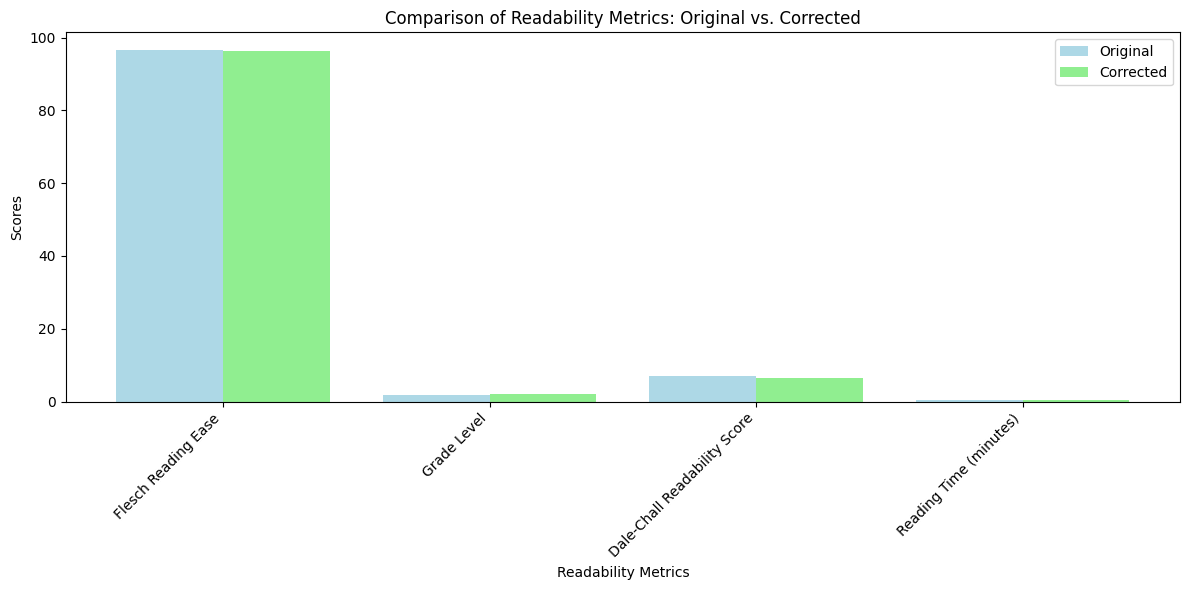

,Flesch Reading Ease,Grade Level,Dale-Chall Readability Score,Reading Time (minutes)
Original,96.59,1.9,7.04,0.34
Corrected,96.38,2.0,6.33,0.35


In [104]:
# Compare readability scores
readability_analysis = analyze_readability(email_content, result['corrected_email'])
readability_analysis

## **Part 3: Sentiment Analysis**

Sentiment analysis evaluates the emotional tone of email content, classifying it as **positive**, **neutral**, or **negative**. This ensures the email's tone aligns with its intended purpose, reducing miscommunication.

### **VADER Sentiment Analysis**
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon-based tool designed for short-form text, such as emails or social media posts.

**Key Features**:
- Assigns scores for:
  - **Positive**, **Neutral**, **Negative**, and **Compound Sentiment** (overall tone: -1 to +1).
- Considers context, including:
  - **Intensifiers** (e.g., "very"), **negations** (e.g., "not happy"), and punctuation or emoticons (e.g., "!!!", ":).

**Implementation**
- **Input**: The email content is analyzed for sentiment scores.
- **Output**: A table and bar chart provide sentiment breakdown and overall tone classification.

In [105]:
def analyze_sentiment(email_content):
    """
    Analyze the sentiment of the given email content.

    Args:
        email_content (str): The email content to analyze.

    Returns:
        dict: Sentiment analysis results, including scores and overall sentiment.
    """
    # Ensure the VADER lexicon is available
    nltk.download('vader_lexicon', quiet=True)

    # Initialize the VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()

    # Perform sentiment analysis
    sentiment_scores = sia.polarity_scores(email_content)

    # Determine the overall sentiment based on the compound score
    compound_score = sentiment_scores["compound"]
    if compound_score >= 0.05:
        overall_sentiment = "Positive"
    elif compound_score <= -0.05:
        overall_sentiment = "Negative"
    else:
        overall_sentiment = "Neutral"

    # Add the overall sentiment to the results
    sentiment_results = {
        "Positive Score": sentiment_scores["pos"],
        "Neutral Score": sentiment_scores["neu"],
        "Negative Score": sentiment_scores["neg"],
        "Compound Score": sentiment_scores["compound"],
        "Overall Sentiment": overall_sentiment
    }

    # Convert sentiment results into a DataFrame
    sentiment_df = pd.DataFrame([sentiment_results])

    # Reset the index for display
    sentiment_df.index = ['']

    # Visualization: Sentiment Scores
    labels = ["Positive", "Neutral", "Negative", "Compound"]
    scores = [
        sentiment_scores["pos"],
        sentiment_scores["neu"],
        sentiment_scores["neg"],
        sentiment_scores["compound"]
    ]

    plt.figure(figsize=(8, 6))
    plt.bar(labels, scores, color=["lightgreen", "lightblue", "salmon", "gray"])
    plt.title("Sentiment Scores")
    plt.xlabel("Sentiment Type")
    plt.ylabel("Score")
    plt.ylim(0, 1)  # Normalized scores
    plt.tight_layout()
    plt.show()

    return sentiment_df

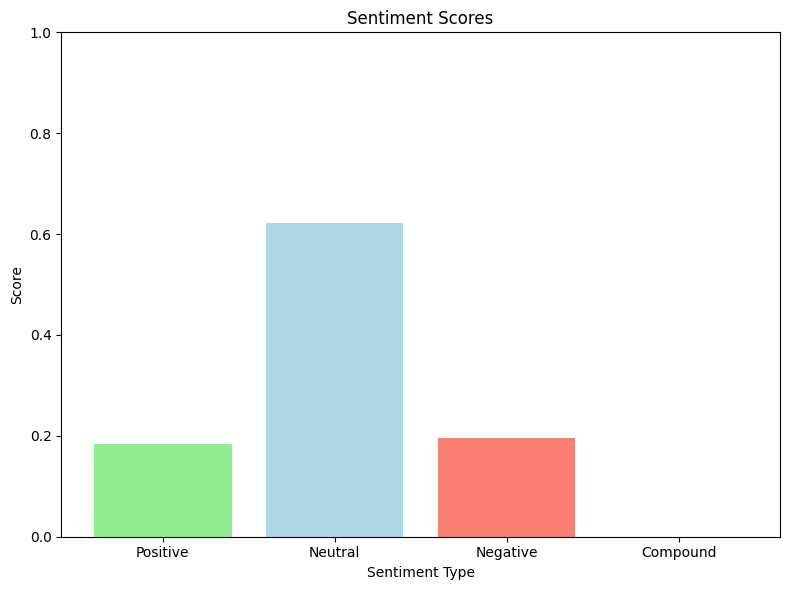

,Positive Score,Neutral Score,Negative Score,Compound Score,Overall Sentiment
,0.184,0.622,0.195,-0.2475,Negative


In [106]:
# Perform sentiment analysis on the corrected email content
sentiment_analysis = analyze_sentiment(result["corrected_email"])
sentiment_analysis


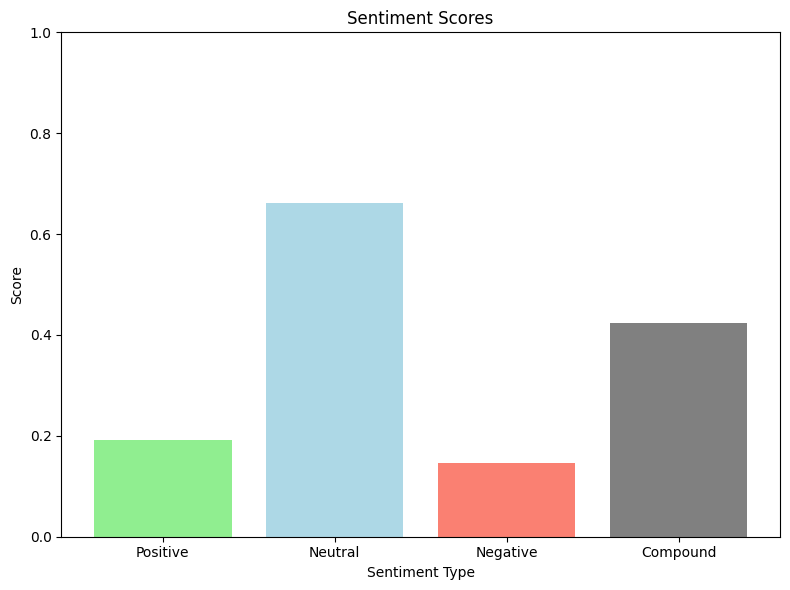

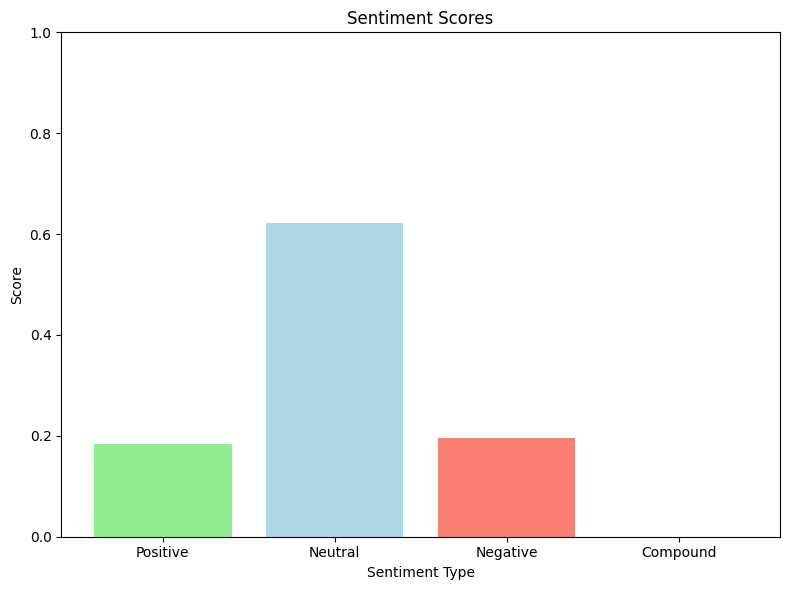

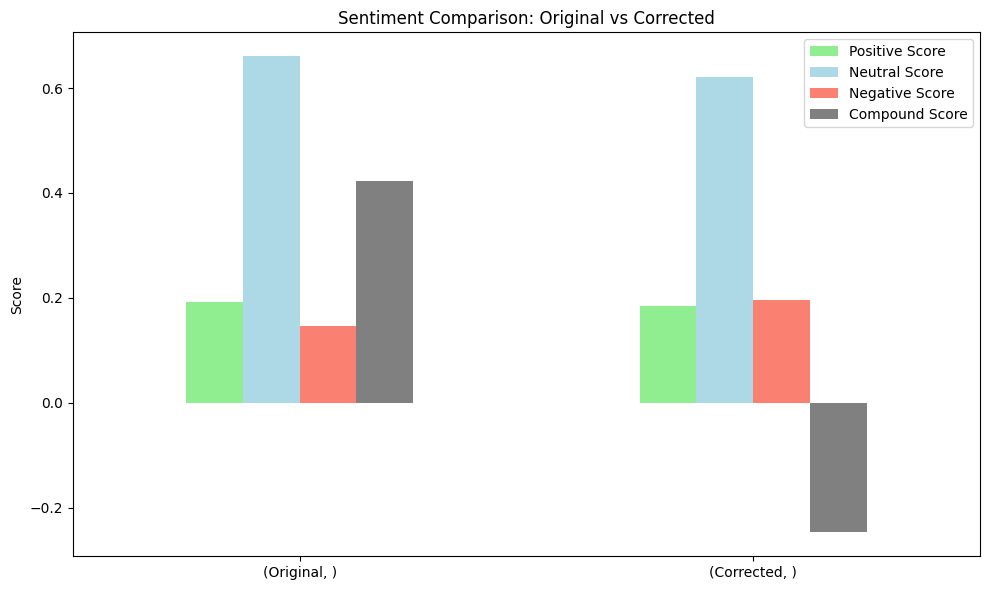

In [107]:
# Comparing Original to Corrected
original_sentiment = analyze_sentiment(email_content)
corrected_sentiment = analyze_sentiment(result["corrected_email"])

sentiment_comparison = pd.concat([original_sentiment, corrected_sentiment], keys=["Original", "Corrected"])
sentiment_comparison.plot(kind='bar', figsize=(10, 6), color=["lightgreen", "lightblue", "salmon", "gray"])
plt.title("Sentiment Comparison: Original vs Corrected")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## **Part 4: Emotion Detection**

### **What Emotion Detection Adds Beyond Sentiment Analysis**
- **Granularity**:
  - Emotion detection identifies **specific emotional states** like joy, sadness, anger, fear, surprise, etc., offering a deeper understanding of emotional tone.
- **Contextual Insight**:
  - Sentiment might label a message as "negative," but emotion detection tells you why. For instance:
    - "I'm upset about the delays" = Anger
    - "I'm worried about the delays" = Fear
    - Both are negative in sentiment but reflect distinct emotions.
- **Practical Applications**:
 - Emotion detection helps fine-tune responses. For example:
    - If **fear** is detected, the response could aim to reassure.
    - If **anger** is detected, the response might focus on resolving specific concerns.
- **Additional Insights for Analysis**:
  - Emotion detection provides a **multidimensional view**. A single text can simultaneously convey anger, sadness, and hope, which sentiment analysis might miss.
- **Visualization and Reporting**:
  - Emotion detection can display **multiple emotions** with varying intensities, whereas sentiment analysis focuses on a single overall label.

### **Tools Used**
- **spaCy (`en_core_web_sm`)**
  - **purpose**: Linguistic Analysis
    - Provides linguistic features such as **tokenization**, **sentence segmentation**, **part-of-speech tagging**, **named entity recognition**, and **dependency parsing**.
  - **Useful for tasks like**:
    - Dividing text into sentences (doc.sents).
    - Understanding grammatical structure (e.g., detecting auxiliary verbs or adverbs for hedging).
    - Extracting syntactic relationships between words.
- **SentimentIntensityAnalyzer (`VADER`)**
  - Described in **Part 3: Sentiment Analysis** as well
  - Used in `detect_problematic_keywords`
    - **Negative Sentences Detection**: Sentences with high negative scores are flagged as problematic.
- **Hugging Face Pipeline (`j-hartmann/emotion-english-distilroberta-base`)**
  - **Purpose: Emotional Tone Analysis**
    - **What It Does**:
      - This model detects **specific emotions** in text such as **joy, anger, fear, sadness, disgust**, and more.
      - Provides a **probability distribution** over detected emotions, showing the likelihood of each emotion being present.
    - **How It's Used**:
      - `analyze_emotional_tone`:
        - Identifies the overall emotional tone of the email.
        - Outputs a dictionary with emotion labels and their associated probabilities.
- **Hugging Face Pipeline (`roberta-large-mnli`)**
  - **Purpose**: Natural Language Inference (NLI)
    - What It Does:
      - NLI is used to determine relationships between two pieces of text:
        - **Entailment**: One statement logically follows from the other.
        - **Neutral**: One statement has no strong relation to the other.
        - **Contradiction**: One statement directly opposes the other.
    - **How It's Used**:
      - **Detect Hedging (`detect_hedging_nli`)**:
        - Compares sentences (premise) with a hypothesis: `"This statement is definitive and certain."`
        - Flags sentences classified as **neutral** with high confidence as potential hedging.
      - **Detect Contradictions (`detect_contradictions`)**:
        - Compares adjacent sentences in the email to find pairs flagged as **contradictory**.


In [108]:
# Detect GPU availability
device = 0 if torch.cuda.is_available() else -1

In [109]:
# Initialize NLP models and tools
nlp = spacy.load("en_core_web_sm")  # for linguistic analysis
sia = SentimentIntensityAnalyzer()  # used in detect_problematic_words
tone_analyzer = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", device=device)  # for emotional tone
nli_model = pipeline("text-classification", model="roberta-large-mnli", device=device) # used to detect hedging phrases and contradictory words

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [110]:
# Function to clean and preprocess the email text
def preprocess_text(text):
    """
    Preprocess the email content to clean and standardize text.
    """
    # Remove extra spaces, newlines, and tabs
    text = re.sub(r'\s+', ' ', text)
    # Strip leading and trailing spaces
    text = text.strip()
    return text

# Function to analyze emotional tone using Hugging Face model
def analyze_emotional_tone(email_content):
    result = tone_analyzer(email_content)
    return result[0] if result else None

# Function to detect indirect or passive-aggressive tone
def detect_passive_aggressive(email_content):
    """
    Detect passive-aggressive tone using a combination of hedging and contradictions.

    Args:
        email_content (str): The email content to analyze.

    Returns:
        list: A list of flagged sentences with passive-aggressive tone.
    """
    hedging = detect_hedging_nli(email_content)
    contradictions = detect_contradictions(email_content)
    # Combine results into a list with positions
    flagged_phrases = []

    # Add hedging phrases with positions
    for phrase in hedging["hedging_phrases"]:
        start_idx = email_content.find(phrase)
        if start_idx != -1:
            flagged_phrases.append({
                "phrase": phrase,
                "type": "Hedging",
                "start": start_idx,
                "end": start_idx + len(phrase)
            })

    # Add contradictions with positions
    for pair in contradictions:
        for sentence in pair:
            start_idx = email_content.find(sentence)
            if start_idx != -1:
                flagged_phrases.append({
                    "phrase": sentence,
                    "type": "Contradiction",
                    "start": start_idx,
                    "end": start_idx + len(sentence)
                })

    return flagged_phrases

def detect_hedging_nli(email_content):
    """
    Use an NLI model to detect hedging phrases.

    Args:
        email_content (str): The email content to analyze.

    Returns:
        list: A list of sentences flagged as hedging and the count.
    """
    # Tokenize the content into sentences using spaCy
    doc = nlp(email_content)
    sentences = [sent.text.strip() for sent in doc.sents if sent.text.strip()]  # Clean whitespace and filter empty sentences

    # Define the hypothesis
    hypothesis = "This statement is definitive and certain."

    # Create batch inputs by combining each sentence with the hypothesis
    batch_inputs = [f"{sentence} {hypothesis}" for sentence in sentences]

    # Perform batch inference with the NLI model
    results = nli_model(batch_inputs, truncation=True)

    # Extract hedging phrases based on model output
    hedging_phrases = [
        sentence for sentence, result in zip(sentences, results)
        if result["label"] == "NEUTRAL" and result["score"] > 0.8  # Adjusted threshold
    ]

    # Return the detected hedging phrases and their count
    return {"hedging_phrases": hedging_phrases, "count": len(hedging_phrases)}



def detect_contradictions(email_content):
    """
    Detect contradictions using sentence pairs.

    Args:
        email_content (str): The email content to analyze.

    Returns:
        list: A list of detected contradictions.
    """
    doc = nlp(email_content)
    contradictions = []

    sentences = [sent.text for sent in doc.sents]
    for i in range(len(sentences) - 1):  # Compare sentence pairs
        pair_result = nli_model(f"{sentences[i]} {sentences[i + 1]}")
        for res in pair_result:
            if res["label"] == "CONTRADICTION" and res["score"] > 0.6:
                contradictions.append((sentences[i], sentences[i + 1]))

    return contradictions

def detect_problematic_keywords(email_content):
    """
    Detect problematic keywords dynamically using sentence-level sentiment analysis.

    Args:
        email_content (str): The email content to analyze.

    Returns:
        list: A list of sentences flagged as problematic.
    """
    doc = nlp(email_content)
    problematic_sentences = []

    for sent in doc.sents:
        sentiment = sia.polarity_scores(sent.text)
        if sentiment["neg"] > 0.5:  # Threshold for high negativity
            problematic_sentences.append(sent.text)

    return list(set(problematic_sentences))  # Unique problematic sentences

# Function to provide suggestions based on analysis
def provide_suggestions(email_content):
    suggestions = []
    if detect_passive_aggressive(email_content):
        suggestions.append("Avoid passive-aggressive phrases. Try to be more direct.")
    if len(detect_problematic_keywords(email_content)) > 0:
        suggestions.append("There are some strong words that might be misinterpreted. Consider using softer language.")
    readability_score = textstat.flesch_reading_ease(email_content)
    if readability_score < 60:
        suggestions.append("The email might be difficult to understand. Try simplifying the language.")
    return suggestions

def visualize_emotional_tone(results):
    """
    Visualize the results of emotional tone analysis, including counts and details.

    Args:
        results (dict): The analysis results, including hedging phrases, contradictions, and problematic sentences.
    """
    # Extract flagged content and counts
    hedging = results.get("Hedging Phrases", {}).get("hedging_phrases", [])
    hedging_count = results.get("Hedging Phrases", {}).get("count", 0)
    contradictions = results.get("Contradictions", [])
    problematic_sentences = results.get("Problematic Sentences", [])

    # Categories and counts for visualization
    categories = ["Hedging", "Contradictions", "Problematic Sentences"]
    counts = [hedging_count, len(contradictions), len(problematic_sentences)]

    # Visualization: Bar Chart of Detected Issues
    plt.figure(figsize=(10, 6))
    plt.bar(categories, counts, color=["lightblue", "lightgreen", "salmon"])
    plt.title("Emotional Tone Analysis")
    plt.ylabel("Count")
    plt.xlabel("Categories")
    plt.ylim(0, max(counts) + 1)
    plt.tight_layout()
    plt.show()

    # Create a detailed table for flagged content
    detailed_content = (
        [{"Category": "Hedging", "Flagged Content": phrase} for phrase in hedging] +
        [{"Category": "Contradictions", "Flagged Content": f"{pair[0]} <-> {pair[1]}"} for pair in contradictions] +
        [{"Category": "Problematic Sentences", "Flagged Content": sentence} for sentence in problematic_sentences]
    )

    # Convert to DataFrame for display
    if detailed_content:
        details_df = pd.DataFrame(detailed_content)
        print("\nDetailed Results:")
        display(details_df)
    else:
        print("No flagged content found.")

In [111]:
def analyze_emotion(email_content):
    """
    Perform a comprehensive analysis of the emotional tone of the email content,
    including an overall emotion summary, hedging, contradictions, problematic
    sentences, and suggestions.

    Args:
        email_content (str): The email content to analyze.

    Returns:
        dict: A dictionary containing analysis results, including overall emotion,
              hedging phrases, contradictions, problematic sentences, and suggestions.
        pd.DataFrame: A DataFrame summarizing the analysis results.
    """
    # Adjust pandas display options for better visualization
    pd.set_option('display.max_colwidth', None)

    # Step 1: Preprocess the email content
    cleaned_email = preprocess_text(email_content)

    # Step 2: Analyze overall emotion using a Hugging Face emotion detection model
    emotion_classifier = pipeline("text-classification", model="bhadresh-savani/distilbert-base-uncased-emotion")
    emotion_results = emotion_classifier(cleaned_email)
    overall_emotion = max(emotion_results, key=lambda x: x['score'])  # Most probable emotion

    # Step 3: Detect hedging phrases using NLI
    hedging_results = detect_hedging_nli(cleaned_email)

    # Step 4: Detect contradictions between sentences
    contradictions = detect_contradictions(cleaned_email)

    # Step 5: Detect problematic sentences based on sentiment analysis
    problematic_sentences = detect_problematic_keywords(cleaned_email)

    # Step 6: Generate suggestions for improvement
    suggestions = provide_suggestions(cleaned_email)

    results = {
        "Overall Emotion": overall_emotion["label"],
        "Emotion Probabilities": {emo["label"]: emo["score"] for emo in emotion_results},
        "Hedging Phrases": hedging_results or {"hedging_phrases": [], "count": 0},
        "Contradictions": contradictions or [],
        "Problematic Sentences": problematic_sentences or [],
        "Suggestions": suggestions or [],
    }

    # Create a summary DataFrame
    data = {
        "Category": ["Overall Emotion", "Emotion Probabilities", "Hedging Phrases", "Contradictions", "Problematic Sentences", "Suggestions"],
        "Details": [
            results["Overall Emotion"],
            results["Emotion Probabilities"],
            ", ".join(results["Hedging Phrases"]["hedging_phrases"]) if results["Hedging Phrases"]["hedging_phrases"] else "None",
            ", ".join([f"{pair[0]} <-> {pair[1]}" for pair in results["Contradictions"]]) if results["Contradictions"] else "None",
            ", ".join(results["Problematic Sentences"]) if results["Problematic Sentences"] else "None",
            "; ".join(results["Suggestions"]) if results["Suggestions"] else "None",
        ]
    }

    results_df = pd.DataFrame(data)

    # Automatically display the DataFrame
    display(results_df)

    # Visualize results
    visualize_emotional_tone(results)
    visualize_emotions_pie_chart(results["Emotion Probabilities"])

    return results

def visualize_emotions_pie_chart(emotion_probabilities):
    """
    Visualize the distribution of emotion probabilities as a pie chart.

    Args:
        emotion_probabilities (dict): A dictionary of emotion labels and their probabilities.
    """
    labels = list(emotion_probabilities.keys())
    # sizes = list(emotion_probabilities.values())
    total = sum(emotion_probabilities.values())
    sizes = [v / total for v in emotion_probabilities.values()]
    colors = ["lightblue", "lightgreen", "salmon", "orange", "purple", "pink"]  # Add more if necessary

    plt.figure(figsize=(8, 6))
    plt.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors
    )
    plt.title("Emotion Distribution")
    plt.axis

,Category,Details
0,Overall Emotion,anger
1,Emotion Probabilities,{'anger': 0.4037230312824249}
2,Hedging Phrases,None
3,Contradictions,None
4,Problematic Sentences,On offends but you are losers.
5,Suggestions,There are some strong words that might be misinterpreted. Consider using softer language.


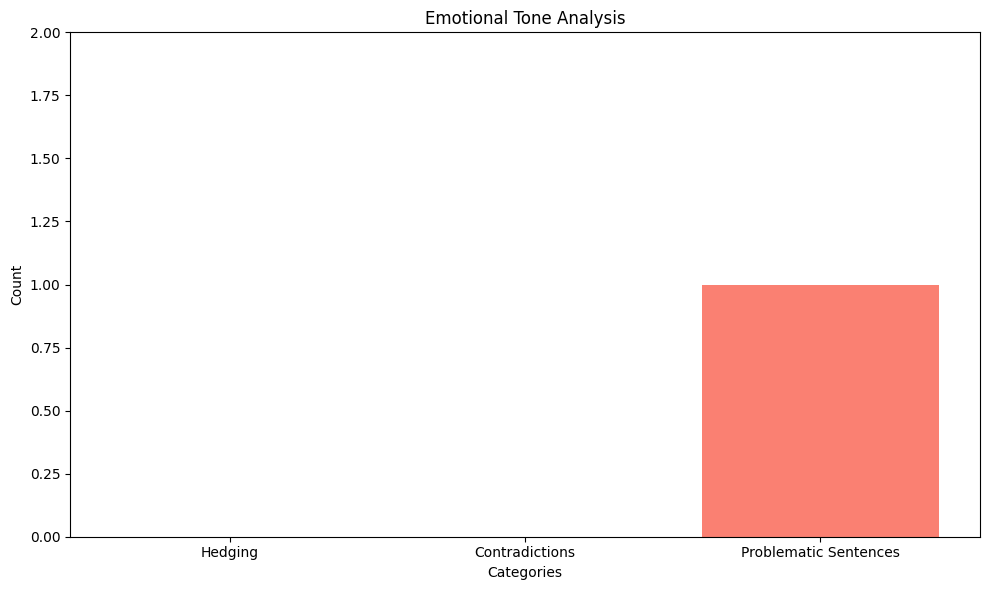


Detailed Results:


,Category,Flagged Content
0,Problematic Sentences,On offends but you are losers.


{'Overall Emotion': 'anger',
 'Emotion Probabilities': {'anger': 0.4037230312824249},
 'Hedging Phrases': {'hedging_phrases': [], 'count': 0},
 'Contradictions': [],
 'Problematic Sentences': ['On offends but you are losers.'],
 'Suggestions': ['There are some strong words that might be misinterpreted. Consider using softer language.']}

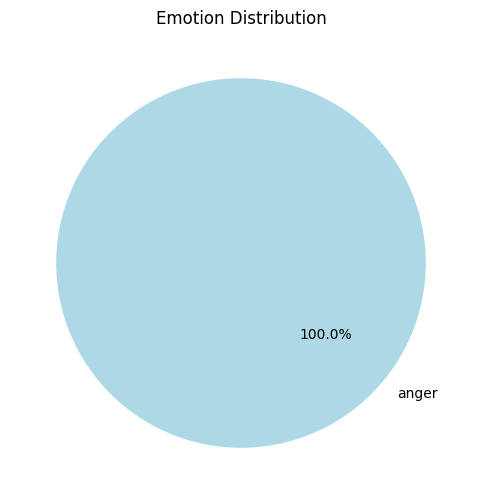

In [112]:
# Analyze emotional tone
# emotional_intent_results = analyze_emotion(email_content)
emotional_intent_results = analyze_emotion(result["corrected_email"])
emotional_intent_results

## **Part 5: Email Refinement with User Interaction**

Builds on the outputs of previous parts to dynamically refine the email through an interactive process. It introduces dynamic issue handling and gives the user control over how flagged issues are addressed.

### **Tools and Techniques Used**
1. **spaCy (`en_core_web_sm`)**
  - **Purpose**: Linguistic Analysis
    - Used to divide text into sentences (doc.sents).
    - Ensures flagged issues (e.g., hedging phrases) are resolved in the correct context.
  - **How It’s Used**:  
    - Identifies the sentence boundaries containing flagged content.
    - Helps in maintaining the grammatical structure of the text after replacements.
2. **textstat**
  - **Purpose**: Readability Analysis
    - Measures the complexity of sentences based on metrics like Flesch Reading Ease.
  - **How It’s Used**:
    - Identifies complex sentences for simplification.
    - Ensures that the rewritten email is easier to read than the original.
3. **User-Driven Refinement**
  - **Purpose**: Interactive Issue Resolution
    - Allows the user to dynamically address flagged issues without predefined replacements.
  - **How It’s Used**:
    - Provides contextual prompts for each flagged issue.
    - Ensures that the user has control over:
      - Replacements.
      - Whether to remove or retain content.
    - Prompts include:
      - Hedging Phrases: "Consider making this more direct."
      - Problematic Sentences: "Consider making this more neutral or polite."
      - Contradictions: "Consider merging or clarifying."
4. **Output from Part 4 (`analyze_emotion`)**
  - **Purpose**: Input Source for Part 5
    - Provides the list of flagged issues for refinement:
      - Hedging phrases (e.g., "maybe," "not really").
      - Contradictory sentences.
      - Problematic sentences (e.g., overly negative or unclear).
  - **How It’s Used**:
    - Each issue flagged in Part 4 becomes an actionable item in Part 5.

### **Strengths of Part 5**
  - **User-Centric Design**:
    - Keeps the user in control of the refinement process.
  - **Fully Dynamic**:
    - Works on any email without requiring hardcoded replacements.
  - **Clear Feedback**:
    - Provides contextual information for each flagged issue, making it easier to understand and act on.
  - **Quantifiable Improvements**:
    - Readability comparison ensures that the process adds measurable value.

In [113]:
# Helper function to prompt user for replacement or removal
def prompt_user_for_action(issue, context):
    """
    Prompt the user to replace, remove, or retain a flagged issue.

    Args:
        issue (str): The flagged issue.
        context (str): Description of the issue and suggestions for improvement.

    Returns:
        str: The replacement text or an empty string if the issue is to be removed.
    """
    print(f"Flagged Issue: {issue}")
    print(f"Context: {context}")
    print("Options:")
    print("1. Replace with a new phrase")
    print("2. Remove this text altogether")
    print("3. Keep it as is")

    while True:
        choice = input("Enter your choice (1/2/3): ").strip()
        if choice == "1":
            return input("Enter your replacement: ").strip()
        elif choice == "2":
            return ""
        elif choice == "3":
            return issue
        else:
            print("Invalid choice. Please enter 1, 2, or 3.")

# Replace hedging phrases dynamically
def replace_hedging_phrases(email_content, hedging_phrases):
    improved_email = email_content
    doc = nlp(email_content)

    for phrase in hedging_phrases:
        for sent in doc.sents:
            if phrase in sent.text:
                replacement = prompt_user_for_action(
                    issue=phrase,
                    context=f"'{phrase}' was flagged as a hedging phrase. Consider making it more direct."
                )
                improved_email = improved_email.replace(phrase, replacement)
    return improved_email

# Simplify problematic sentences dynamically
def simplify_problematic_sentences(email_content, problematic_sentences):
    improved_email = email_content

    for sentence in problematic_sentences:
        replacement = prompt_user_for_action(
            issue=sentence,
            context=f"'{sentence}' was flagged as problematic. Consider making it more neutral or polite."
        )
        improved_email = improved_email.replace(sentence, replacement)
    return improved_email

# Resolve contradictions dynamically
def resolve_contradictions(email_content, contradictions):
    improved_email = email_content

    for pair in contradictions:
        contradiction_text = f"{pair[0]} and {pair[1]}"
        replacement = prompt_user_for_action(
            issue=contradiction_text,
            context="These sentences were flagged as contradictory. Consider merging or clarifying."
        )
        improved_email = improved_email.replace(pair[0], replacement).replace(pair[1], "")
    return improved_email

# Simplify based on readability dynamically
def simplify_based_on_readability(email_content):
    sentences = email_content.split(". ")
    simplified_email = []

    for sentence in sentences:
        if textstat.flesch_reading_ease(sentence) < 50:  # Arbitrary complexity threshold
            replacement = prompt_user_for_action(
                issue=sentence,
                context="This sentence is too complex. Simplify it for better readability."
            )
            simplified_email.append(replacement)
        else:
            simplified_email.append(sentence)

    return ". ".join(simplified_email)

# Combined function using Part 4 output
def generate_better_email(email_content, part4_results):
    """
    Generate a rewritten version of the email based on dynamic NLP techniques.

    Args:
        email_content (str): The original email content.
        part4_results (dict): Results from the `analyze_emotion` function.

    Returns:
        str: A rewritten version of the email.
    """
    # Step 1: Replace Hedging Phrases
    improved_email = replace_hedging_phrases(email_content, part4_results["Hedging Phrases"]["hedging_phrases"])

    # Step 2: Simplify Problematic Sentences
    improved_email = simplify_problematic_sentences(improved_email, part4_results["Problematic Sentences"])

    # Step 3: Resolve Contradictions
    improved_email = resolve_contradictions(improved_email, part4_results["Contradictions"])

    # Step 4: Simplify Sentences Based on Readability
    improved_email = simplify_based_on_readability(improved_email)

    return improved_email

In [114]:
improved_email = generate_better_email(result['corrected_email'], emotional_intent_results)
print("\nFinal Improved Email:")
print(improved_email)

Flagged Issue: On offends but you are losers.
Context: 'On offends but you are losers.' was flagged as problematic. Consider making it more neutral or polite.
Options:
1. Replace with a new phrase
2. Remove this text altogether
3. Keep it as is
Enter your choice (1/2/3): 2

Final Improved Email:

Hi John,

I hope you're doing well. I don't mean to be rude, but we really need to talk about the report.
Furthermore, I am very upset about the missed deadlines.  I'm glad I don't work with you.
You always say to will send it, but it never happens. I shouldn't have to remind again.
Please get it to me bye tomorrow.

Best,
Mark



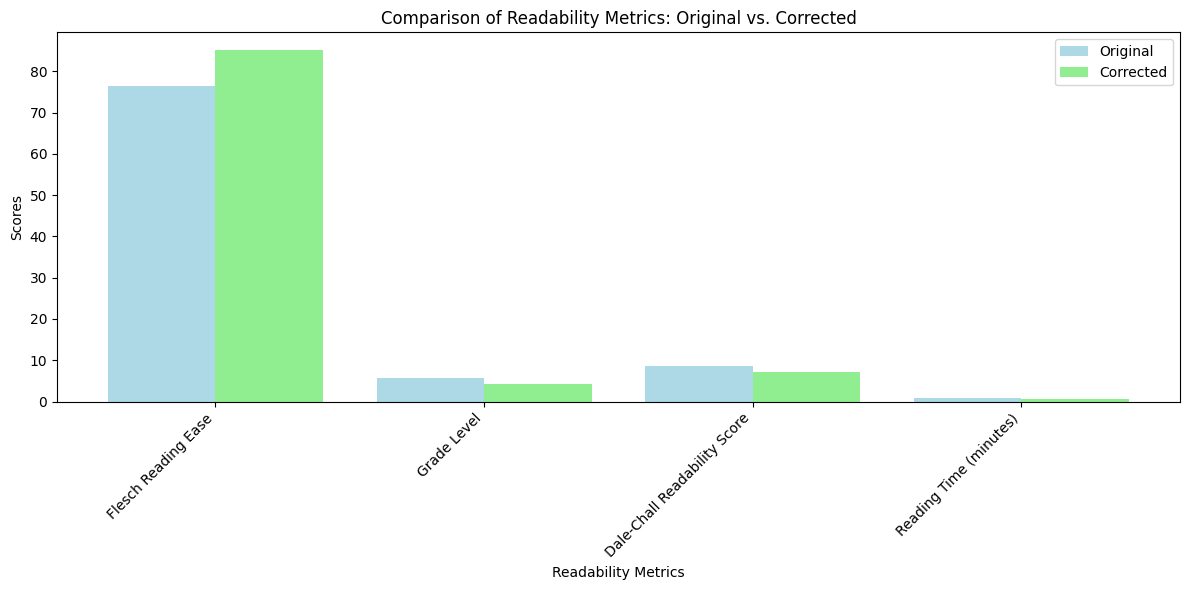

,Flesch Reading Ease,Grade Level,Dale-Chall Readability Score,Reading Time (minutes)
Original,76.32,5.6,8.71,0.78
Corrected,85.18,4.2,7.19,0.64


In [98]:

final_readability_analysis = analyze_readability(email_content, improved_email)
final_readability_analysis